In [1]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
# matplotlib.use("Agg")

# import the necessary packages
import time
import pandas as pd
import seaborn as sn
import keras
import os
import cv2
import pickle
import random
import argparse
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Dense
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import Nadam
from keras.optimizers import RMSprop
from keras.losses import logcosh, binary_crossentropy
from keras.activations import relu, elu, sigmoid
from keras.preprocessing.image import ImageDataGenerator
# import matplotlib
# matplotlib.use("Agg")

Using TensorFlow backend.


In [2]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 200
INIT_LR = 1e-2
BS = 64
IMAGE_DIMS = (224, 224, 3)

In [3]:
from imutils import paths

imagePaths = sorted(list(paths.list_images("anger_classification_majority_trimmed")))
random.seed(42)
random.shuffle(imagePaths)
imagePaths

['anger_classification_majority_trimmed\\anger\\anger_664.jpg',
 'anger_classification_majority_trimmed\\non_anger\\non_anger_667.jpg',
 'anger_classification_majority_trimmed\\non_anger\\non_anger_708.jpg',
 'anger_classification_majority_trimmed\\non_anger\\non_anger_556.jpg',
 'anger_classification_majority_trimmed\\anger\\anger_455.jpg',
 'anger_classification_majority_trimmed\\anger\\anger_16.jpg',
 'anger_classification_majority_trimmed\\non_anger\\non_anger_357.jpg',
 'anger_classification_majority_trimmed\\anger\\anger_779.jpg',
 'anger_classification_majority_trimmed\\anger\\anger_65.jpg',
 'anger_classification_majority_trimmed\\non_anger\\non_anger_210.jpg',
 'anger_classification_majority_trimmed\\anger\\anger_290.jpg',
 'anger_classification_majority_trimmed\\non_anger\\non_anger_35.jpg',
 'anger_classification_majority_trimmed\\non_anger\\non_anger_485.jpg',
 'anger_classification_majority_trimmed\\non_anger\\non_anger_779.jpg',
 'anger_classification_majority_trimmed\\no

In [4]:
from keras.preprocessing.image import img_to_array

data = []
labels = []

# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [5]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(
    data.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 1838.09MB


In [6]:
from sklearn.preprocessing import LabelBinarizer

# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [7]:
from sklearn.model_selection import train_test_split

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.2, random_state=42)

In [8]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [9]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(256, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(256, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(256, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(256, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

In [10]:
print("[INFO] compiling model...")
model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
    depth=IMAGE_DIMS[2], classes=len(lb.classes_))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
print("[INFO] done compiling.")

[INFO] compiling model...
[INFO] done compiling.


In [11]:
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [12]:
# train the network
print("[INFO] training network...")
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)#, class_weight={0:3, 1:1})

# save the model to disk
print("[INFO] serializing network...")
model.save("anger_trimmed_SmallVGG_200_epochs.model")

[INFO] training network...
Epoch 1/200
19/19 [==============================] - 11s 564ms/step - loss: 1.8841 - accuracy: 0.5556 - val_loss: 71791.9856 - val_accuracy: 0.4728
Epoch 2/200
19/19 [==============================] - 9s 475ms/step - loss: 1.1789 - accuracy: 0.5616 - val_loss: 18499.9995 - val_accuracy: 0.4728
Epoch 3/200
19/19 [==============================] - 9s 473ms/step - loss: 1.0202 - accuracy: 0.5582 - val_loss: 879.4165 - val_accuracy: 0.4728
Epoch 4/200
19/19 [==============================] - 9s 458ms/step - loss: 0.9169 - accuracy: 0.5927 - val_loss: 59.9517 - val_accuracy: 0.5080
Epoch 5/200
19/19 [==============================] - 9s 468ms/step - loss: 0.9918 - accuracy: 0.5278 - val_loss: 37.3123 - val_accuracy: 0.4728
Epoch 6/200
19/19 [==============================] - 9s 466ms/step - loss: 0.9668 - accuracy: 0.5734 - val_loss: 2.3480 - val_accuracy: 0.4984
Epoch 7/200
19/19 [==============================] - 9s 479ms/step - loss: 1.0371 - accuracy: 0.5312 -

Epoch 58/200
19/19 [==============================] - 9s 472ms/step - loss: 0.6186 - accuracy: 0.6745 - val_loss: 0.7244 - val_accuracy: 0.5367
Epoch 59/200
19/19 [==============================] - 9s 467ms/step - loss: 0.6181 - accuracy: 0.6737 - val_loss: 0.7017 - val_accuracy: 0.6709
Epoch 60/200
19/19 [==============================] - 9s 464ms/step - loss: 0.6268 - accuracy: 0.6610 - val_loss: 0.6657 - val_accuracy: 0.6134
Epoch 61/200
19/19 [==============================] - 9s 475ms/step - loss: 0.6180 - accuracy: 0.6594 - val_loss: 0.6868 - val_accuracy: 0.5623
Epoch 62/200
19/19 [==============================] - 9s 476ms/step - loss: 0.5859 - accuracy: 0.6914 - val_loss: 0.6391 - val_accuracy: 0.6454
Epoch 63/200
19/19 [==============================] - 9s 468ms/step - loss: 0.6014 - accuracy: 0.6720 - val_loss: 0.6770 - val_accuracy: 0.6358
Epoch 64/200
19/19 [==============================] - 9s 469ms/step - loss: 0.6464 - accuracy: 0.6653 - val_loss: 0.6622 - val_accuracy:

Epoch 115/200
19/19 [==============================] - 9s 455ms/step - loss: 0.5013 - accuracy: 0.7405 - val_loss: 0.7395 - val_accuracy: 0.6294
Epoch 116/200
19/19 [==============================] - 9s 476ms/step - loss: 0.5049 - accuracy: 0.7492 - val_loss: 0.7117 - val_accuracy: 0.6581
Epoch 117/200
19/19 [==============================] - 9s 464ms/step - loss: 0.5091 - accuracy: 0.7437 - val_loss: 0.7401 - val_accuracy: 0.6102
Epoch 118/200
19/19 [==============================] - 9s 465ms/step - loss: 0.4929 - accuracy: 0.7462 - val_loss: 0.7157 - val_accuracy: 0.6230
Epoch 119/200
19/19 [==============================] - 9s 465ms/step - loss: 0.5008 - accuracy: 0.7555 - val_loss: 0.7102 - val_accuracy: 0.6613
Epoch 120/200
19/19 [==============================] - 9s 467ms/step - loss: 0.5267 - accuracy: 0.7243 - val_loss: 1.0602 - val_accuracy: 0.5080
Epoch 121/200
19/19 [==============================] - 9s 473ms/step - loss: 0.5041 - accuracy: 0.7487 - val_loss: 0.7472 - val_ac

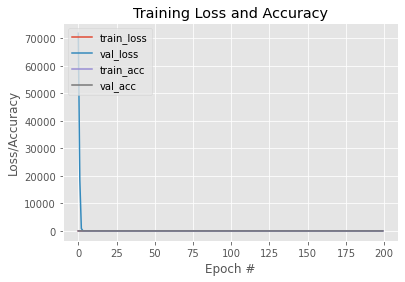

<Figure size 432x288 with 0 Axes>

In [13]:
plt.style.use("ggplot")
%matplotlib inline
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()
plt.savefig("anger_trimmed_SmallVGG_200_epochs.png")

In [14]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
 

# predict probabilities for test set
yhat_probs = model.predict(testX, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(testX, verbose=0)

Classification report: 
---------------------------------------------------------- 
              precision    recall  f1-score   support

       anger       0.52      0.88      0.65       148
   non-anger       0.71      0.27      0.39       165

    accuracy                           0.56       313
   macro avg       0.61      0.57      0.52       313
weighted avg       0.62      0.56      0.51       313

---------------------------------------------------------- 
Accuracy score: 0.555911
Precision score: 0.709677
Recall score: 0.266667
F1 score: 0.387665
---------------------------------------------------------- 
Confusion matrix: 
[[130  18]
 [121  44]]


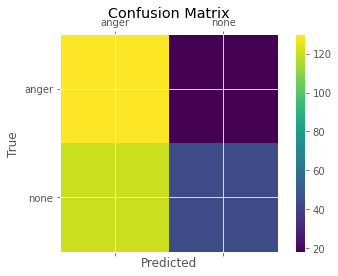

[[130  18]
 [121  44]]


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

classif_report = classification_report(testY, yhat_classes, target_names=['anger', 'non-anger'])
print('Classification report: ')
print('---------------------------------------------------------- ')
print(classif_report)

print('---------------------------------------------------------- ')
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testY, yhat_classes)
print('Accuracy score: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testY, yhat_classes)
print('Precision score: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testY, yhat_classes)
print('Recall score: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testY, yhat_classes)
print('F1 score: %f' % f1)
print('---------------------------------------------------------- ')

# confusion matrix
labels = ['anger', 'none']
matrix = confusion_matrix(testY, yhat_classes)
print('Confusion matrix: ')
print(matrix)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix)
plt.title('Confusion Matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_anger_trimmed_SmallVGG_200_epochs.png')
plt.show()
print(matrix)